In [1]:
using DataFrames, CSV, Measurements, Unitful, Statistics
UNITFUL_FANCY_EXPONENTS = false # helps display better on graphs
using Interpolations
using Plots
using LaTeXStrings
using StringEncodings
using UnitfulLatexify
using MathTeXEngine
# https://github.com/JuliaPhysics/PhysicalConstants.jl

In [2]:
scalefontsizes(1.2) # Makes all fonts larger. 
# ^ Repeatedly calling this keeps scaling the font, so we set it aside.

In [17]:
Plots.gr()
#Plots.plotlyjs()
#Plots.pythonplot() # Important for working with unitful units
default(fontfamily = "Helvetica", #"Computer Modern", # Serif,
        framestyle = :box,
        grid = false,
        label = nothing, # Disables the default label that appears.
        linewidth = 2,
        #ticks = :native, # Allows interactive zooming with appropriate tick marks.
        #size = 1500 .* (3/2, 1),
        palette = :Paired_10, # https://docs.juliaplots.org/latest/generated/colorschemes/
        title_align = :left,
        titlefontvalign = :top,
        legendposition = :topright,
        size = [920, 690],
        margin = (10, :px),
        )
# https://discourse.julialang.org/t/nice-fonts-with-plots-gr-and-latexstrings/60037/4

# The Scheme.

1. Thermal distribution of velocities of a Yb gas in our cell.

2. Doppler shift of pump frequency given velocity.

3. Distribution of detuning due to doppler shift from thermal velocity.

# Other references.

* [The Yb Hollow Cathode Lamp (HCL).](https://www.perkinelmer.com/product/lumina-hollow-cathode-2-lamp-yb-n3050190)

In [12]:
# Constants.
c = u"c0";
m_Yb = (173.04 ± 0.01)u"u"; # Atomic mass of Yb in atomic mass units. https://physics.nist.gov/PhysRefData/Handbook/Tables/ytterbiumtable1.htm.
T_boiling_Yb = 1469u"K"; # Boiling point of Yb.
ω_laser = u"Hz"(2π * u"c0" / (399 ± 1)u"nm");
ω_width_laser = 2π * c / 5u"nm"

In [5]:
# Maxwell-Boltzmann distribution of thermal velocities for a classical gas. Produces a unitless probability per speed.
# v = magnitude of velocity in question.
# m = particle mass.
# T = temperature of entire gas (must be uniform, in equilibrium, etc.)
# u"k" = Unitful package constant, the Boltzmann constant.
MB_pdf(v, m, T) = u"(m/s)^-1"(sqrt(2/π) * (m / (u"k" * T))^(3/2) * v^2 * exp(-m * v^2 / (2u"k" * T)))
# Note that the distribution of v-vectors is isotropic in direction, with magnitudes given by the above.

MB_pdf (generic function with 1 method)

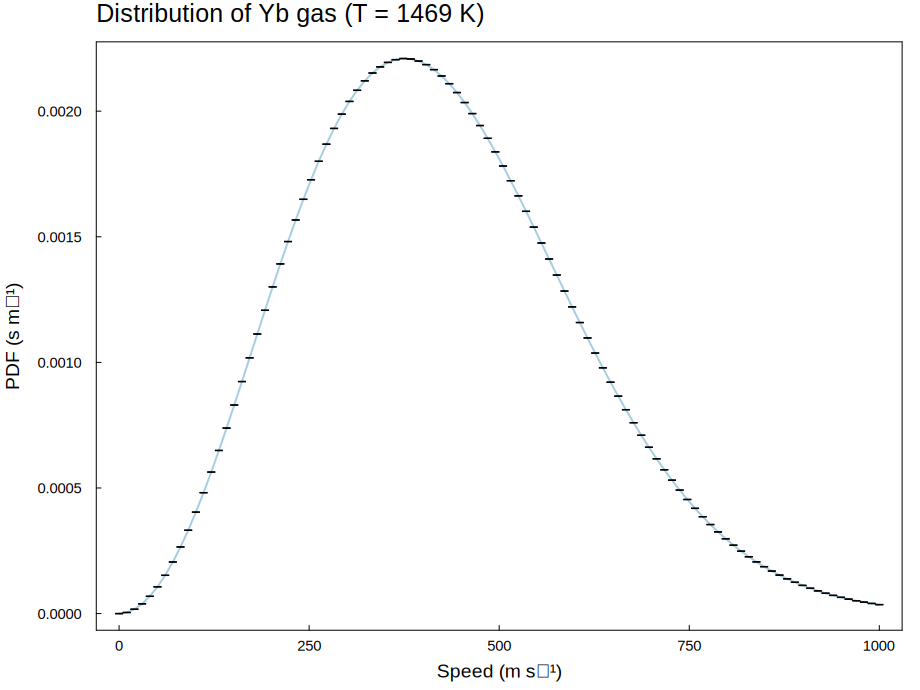

In [18]:
vs = range(0, 1e3, length = 100)u"m/s"
plot(vs, MB_pdf.(vs, m_Yb, T_boiling_Yb),
    title = "Distribution of Yb gas (T = $T_boiling_Yb)",
    xlabel = "Speed",
    ylabel = "PDF",)

In [7]:
# Increase in ω_0 due to parallel velocity v.
# v > 0: moving towards light source (blueshift).
doppler_shift(v, ω_0) = ω_0 * (sqrt((u"c0" + v) / (u"c0" - v)) - 1)

# Gives the speed |v| as a function of the doppler shift.
# Inverse of doppler_shift
speed(s, ω_0) = (-c * s^2 - 2 * c * s * ω_0) / (s^2 + 2s * ω_0 + 2ω_0^2)

speed (generic function with 1 method)

In [ ]:
ω_laser = u"THz"(2π*u"c0" / (399 ± 1)u"nm")

4721.0 ± 12.0 THz

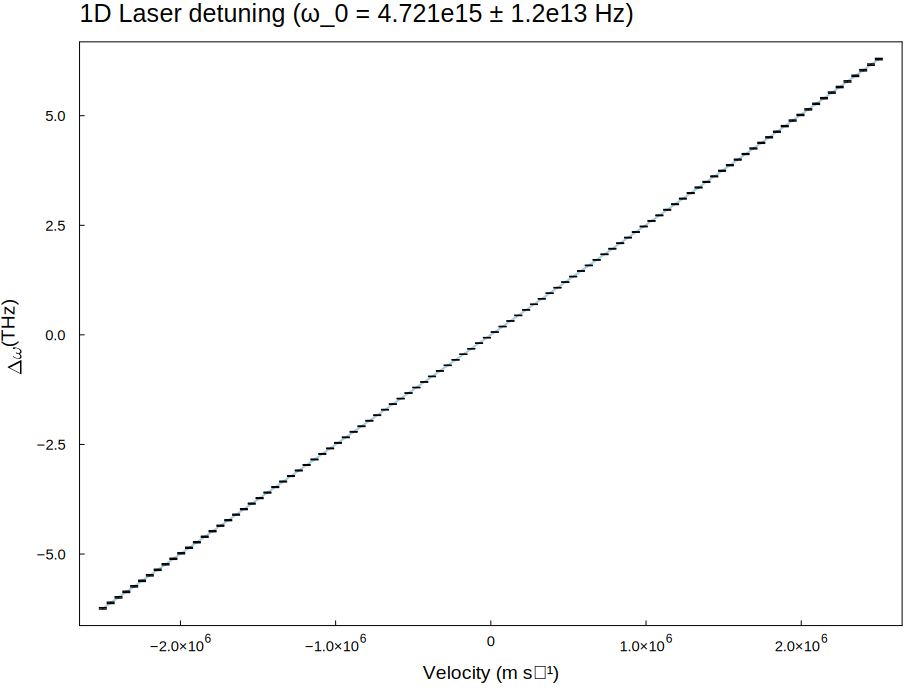

In [20]:
vs = range(-2.5e6, 2.5e6, length = 100)u"m/s"
doppler_shift(10u"m/s", ω_laser)

plot(vs, doppler_shift.(vs, ω_laser) .* (1 / 2π),
    title = "1D Laser detuning (ω_0 = $ω_laser)",
    #ylabel = "Frequency change",
    ylabel = L"\Delta\omega",
    xlabel = "Velocity",
    yunit = u"THz")

In [14]:
# Derivative of speed with respect to doppler shift s.
∂v_∂s(s, ω_0) = (4c * ω_0^2 * (s + ω_0)) / (s^2 + 2s * ω_0 + 2 * ω_0^2)^2

∂v_∂s (generic function with 1 method)

In [15]:
# Distribution of doppler shifts (detuning) for a classical gas at temperature T, mass m.
# Use absolute value because PDFs should be strictly > 0.
shift_pdf(s, ω_0, m, T) = u"Hz^-1"(MB_pdf(speed(s, ω_0), m, T) * abs(∂v_∂s(s, ω_0)))

shift_pdf (generic function with 1 method)

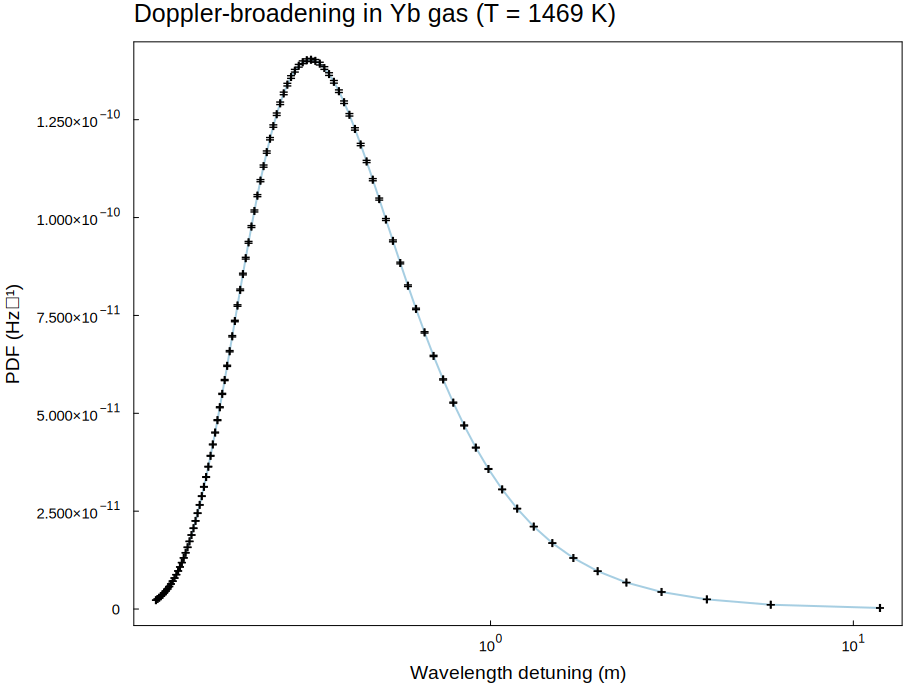

In [22]:
v_effective_support = range(0, 1e3, length = 100)u"m/s"
s_eff_support = doppler_shift.(v_effective_support, ω_laser)
ω_to_λ(ω) = 2π*c/ω
plot(s_eff_support .|> ω_to_λ, shift_pdf.(s_eff_support, ω_laser, m_Yb, T_boiling_Yb),
    title = "Doppler-broadening in Yb gas (T = $T_boiling_Yb)",
    ylabel = "PDF",
    xunit = u"m",
    xscale = :log10,
    xlabel = "Wavelength detuning")

# Population simulation.
1. Set $N$ atoms.
2. Advance to next timestep.
3. Randomly draw detunings for each atom.
4. Advance their state according to their detunings.
5. Roll for stimulated emission back to ground state.
6. Go to step (2) and repeat until a set amount of time has passed.